# Trend

Model long-term changes with moving averages and the time dummy.


### What is Trend?

The **trend** component of a time series represents a persistent, long-term change in the mean of the series. The trend is the slowest-moving part of a series, the part representing the largest time scale of importance. In a time series of product sales, an increasing trend might be the effect of a market expansion as more people become aware of the product year by year.

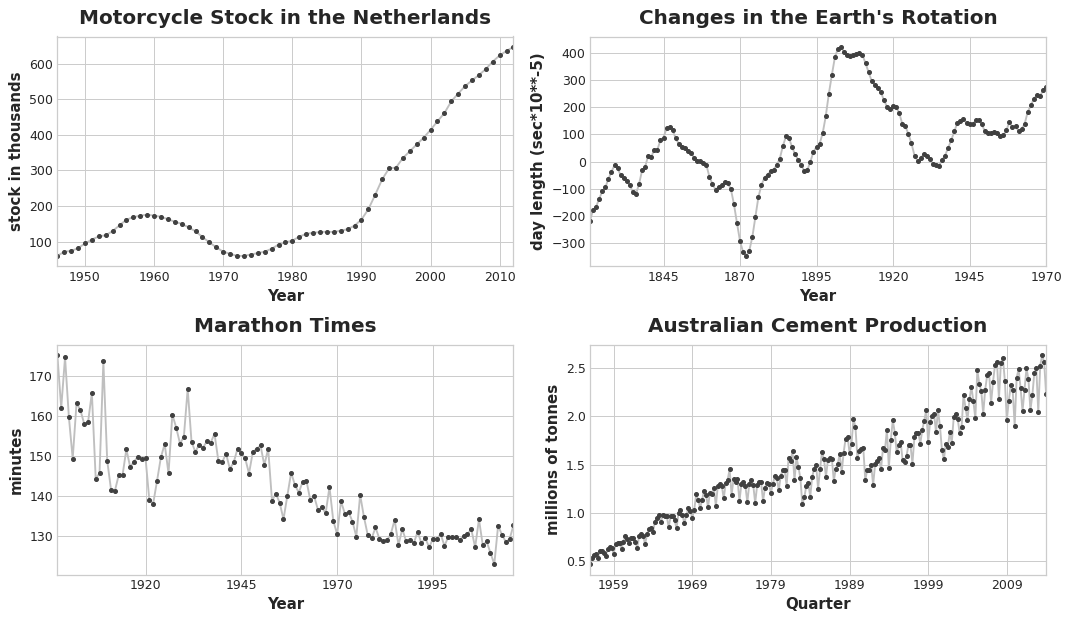



### Moving Average Plot

To see what kind of trend a time series might have, we can use a moving average plot. To compute a moving average of a time series, we compute the average of the values within a sliding window of some defined width. Each point on the graph represents the average of all the values in the series that fall within the window on either side. The idea is to smooth out any short-term fluctuations in the series so that only long-term changes remain.

![SegmentLocal](trend.gif "segment")

Notice how the Mauna Loa series above has a repeating up and down movement year after year -- a short-term, seasonal change. For a change to be a part of the trend, it should occur over a longer period than any seasonal changes. To visualize a trend, therefore, we take an average over a period longer than any seasonal period in the series. For the Mauna Loa series, we chose a window of size 12 to smooth over the season within each year.

### Engineering Trend

For linear trend: `target = a * time + b` 

For quadratic trend: `target = a * time **2 + b * time + c` 

Train `a`, `b`, and `c` in LinearRegression Model

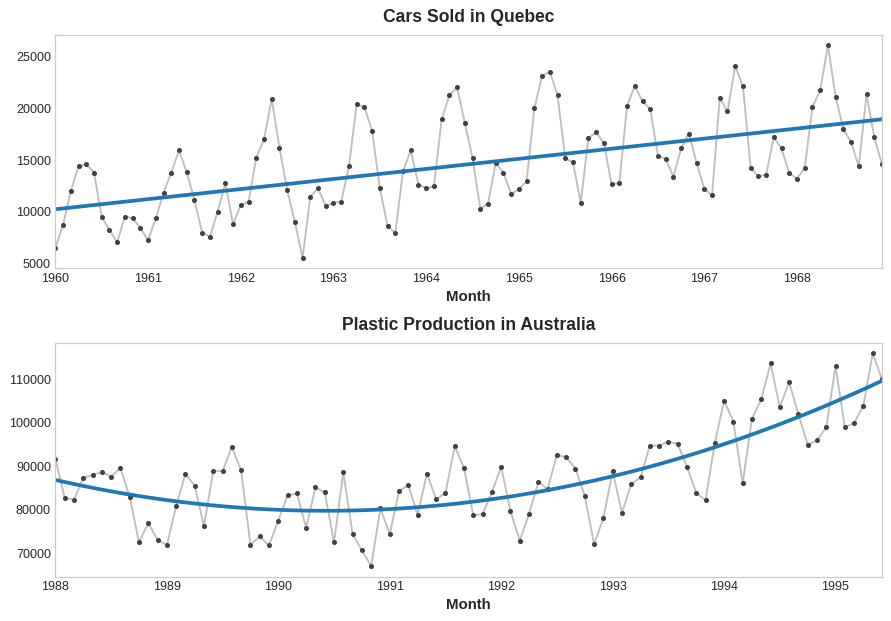
    

### Example - Tunnel Traffic

In [2]:
import pandas as pd
import numpy as np

tunnel = pd.read_csv( "./tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day")
tunnel = tunnel.to_period()

tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


 Since this series has daily observations, let's choose a window of 365 days to smooth over any short-term changes within the year.

To create a moving average, first use the `rolling` method to begin a windowed computation. Follow this by the `mean` method to compute the average over the window.

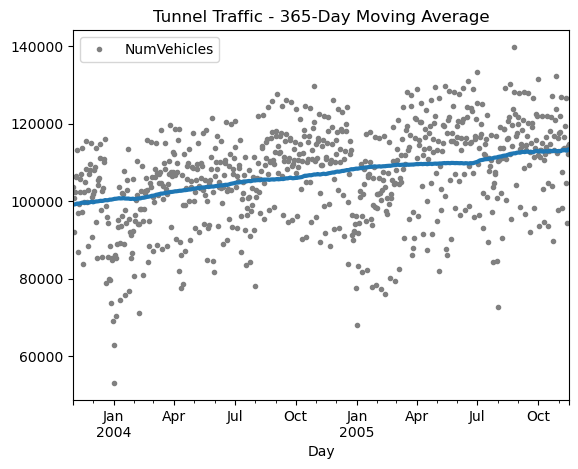

In [3]:
moving_average = tunnel.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = tunnel.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
);

Function from the `statsmodels` library called `DeterministicProcess` help us avoid some tricky failure cases that can arise with time series and linear regression.   
The order argument refers to polynomial order: 1 for linear, 2 for quadratic, 3 for cubic, and so on.

In [4]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=tunnel.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
Day,,
2003-11-01,1.0,1.0
2003-11-02,1.0,2.0
2003-11-03,1.0,3.0
2003-11-04,1.0,4.0
2003-11-05,1.0,5.0


In [5]:
from sklearn.linear_model import LinearRegression

y = tunnel["NumVehicles"]  # the target

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

<Axes: title={'center': 'Tunnel Traffic - Linear Trend'}, xlabel='Day'>

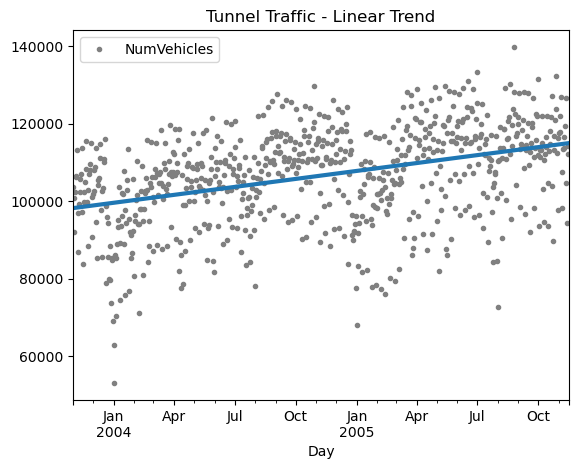

In [6]:
ax = tunnel.plot(style=".", color="0.5", title="Tunnel Traffic - Linear Trend")
y_pred.plot(ax=ax, linewidth=3, label="Trend")

To make a forecast, we apply our model to "out of sample" features. "Out of sample" refers to times outside of the observation period of the training data. Here's how we could make a 30-day forecast:

In [7]:
X = dp.out_of_sample(steps=30)
y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2005-11-17    114981.801146
2005-11-18    115004.298595
2005-11-19    115026.796045
2005-11-20    115049.293494
2005-11-21    115071.790944
Freq: D, dtype: float64

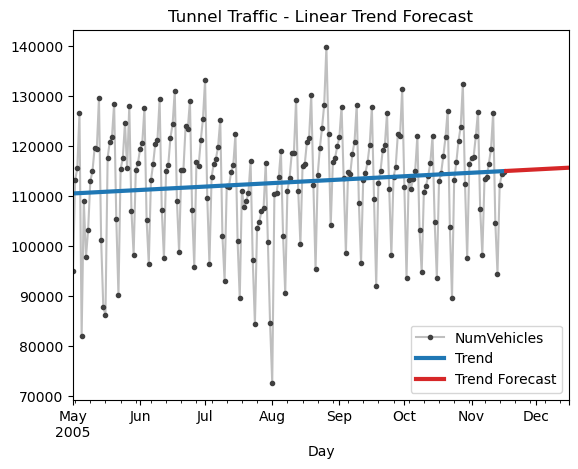

In [21]:
import matplotlib.pyplot as plt

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

ax = tunnel["2005-05":].plot(title="Tunnel Traffic - Linear Trend Forecast", **plot_params)
ax = y_pred["2005-05":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()